# EEG analysis of the Focus Protocol with Deep Learning
In this notebook, I am going to analyze EEG signals collected during afternoon work sessions for days where I perfomed the Focus Protocol right before the session (eeg_focus_protocol_cleaned.csv) and on days where no protocol was performed (eeg_no_protocol_cleaned.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its  Research Kit.

In this notebook I will cover:
- Extracting power in the alpha band (the feature of choice)
- Removing outliers

In 2 separate notebooks I will cover:

- Signal processing and artifact rejection
- Use a convolutional neural network to identify if there are differences between the EEG datasets

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os

In [42]:
# Parameters
sampling_rate = 500  # Hz
window_size_seconds = 2  # 1-second windows
window_size = window_size_seconds*sampling_rate
alpha_band = (8, 12)


In [43]:
# Function to compute alpha power for a signal chunk
def compute_alpha_power(signal_chunk, fs, fmin=alpha_band[0], fmax=alpha_band[1]):
    freqs, psd = signal.welch(signal_chunk.values, fs=fs, nperseg=len(signal_chunk))
    alpha_idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    alpha_power = np.trapz(psd[alpha_idx], freqs[alpha_idx])
    return alpha_power

In [44]:
# Function to compute alpha power time series
def compute_alpha_time_series(df, fs):
    alpha_dict = {ch: [] for ch in df.columns}
    num_chunks = len(df) // window_size

    for i in range(num_chunks):
        start = i * window_size
        end = start + window_size
        for ch in df.columns:
            chunk = df[ch].iloc[start:end]
            if len(chunk) == window_size:
                alpha_power = compute_alpha_power(chunk, fs)
                alpha_dict[ch].append(alpha_power)
    return pd.DataFrame(alpha_dict)

In [45]:
focus_protocol_filtered_df = pd.read_csv('../data/cleaned/eeg_focus_protocol_cleaned.csv', index_col=0)
no_protocol_filtered_df = pd.read_csv('../data/cleaned/eeg_no_protocol_cleaned.csv', index_col=0)
# A gigabyte of data

In [46]:
focus_protocol_filtered_df

,Ch1RawEEG,Ch2RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch8RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG
0,-0.021258,-0.045832,0.074296,0.046470,-0.013717,0.072557,0.055804,0.019139,0.652974
1,-0.170300,-0.238830,0.769358,0.424006,-0.119064,0.722397,0.494074,0.180329,5.004079
2,-0.645818,-0.328675,3.743482,1.864231,-0.490025,3.433847,2.106893,0.818533,18.105527
3,-1.578691,0.748226,11.518319,5.333561,-1.285867,10.446611,5.845146,2.413197,42.659688
4,-2.862784,4.238888,25.619967,11.325716,-2.452174,23.070778,11.995147,5.256122,76.611693
...,...,...,...,...,...,...,...,...,...
2475616,-8.221118,-22.142171,-0.417933,-5.892202,0.107077,25.641272,0.566053,0.511206,10.268977
2475617,-7.372785,-19.763915,1.284966,-5.434640,0.263298,20.292721,-0.025076,0.399574,5.059552
2475618,-5.908798,-15.817627,3.108305,-4.641126,0.570354,14.326837,-0.931268,0.815379,1.147530
2475619,-4.647728,-12.609283,4.008761,-3.951145,0.892152,11.321528,-1.412561,2.010286,1.102563


In [ ]:
# Compute for both morning and evening
focus_protocol_alpha_df = compute_alpha_time_series(focus_protocol_filtered_df, sampling_rate)
no_protocol_alpha_df = compute_alpha_time_series(no_protocol_filtered_df, sampling_rate)
# this takes nearly a minute

In [48]:
focus_protocol_alpha_df

,Ch1RawEEG,Ch2RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch8RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG
0,41.023960,68.431303,56.693568,15.275228,16.575960,94.329769,63.798097,40.511743,61.828850
1,24.859607,85.919791,27.557201,62.165621,3.510889,120.294502,46.513060,59.202293,32.577242
2,1.250639,4.303077,2.115545,0.647589,0.323929,12.576345,6.321870,9.902272,16.290599
3,1.263156,7.480282,1.517097,0.855395,0.499635,22.192017,4.078655,8.098361,76.880427
4,0.835683,6.339105,4.690325,2.089450,1.885279,18.631313,6.577065,11.017780,45.673350
...,...,...,...,...,...,...,...,...,...
2470,1.042938,1.587769,1.826297,0.345111,0.628854,29.282361,13.672247,21.832481,20.181814
2471,0.469905,1.740774,0.779934,0.456086,0.351120,10.544891,4.725846,8.030459,8.068523
2472,1.695197,2.090653,1.946132,0.435712,1.324214,17.707136,9.957105,17.977382,17.121922
2473,1.539345,2.622663,1.875730,0.425165,1.458816,16.873579,8.778950,19.994804,8.343138


Text(0.5, 1.0, 'Alpha power after Protocol')

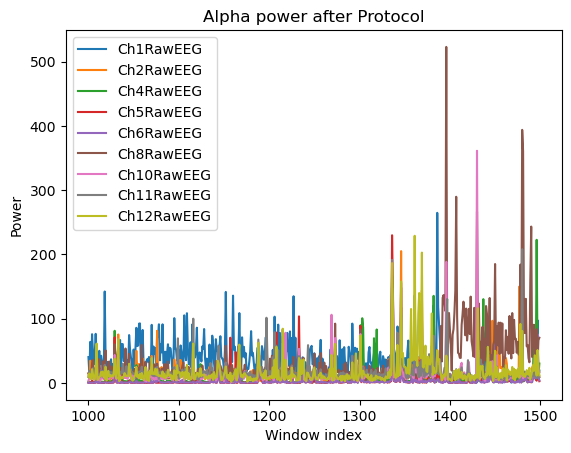

In [49]:
focus_protocol_alpha_df.iloc[1000:1500].plot()
plt.xlabel('Window index')
plt.ylabel('Power')
plt.title('Alpha power after Protocol')

Text(0.5, 1.0, 'Alpha power No Protocol')

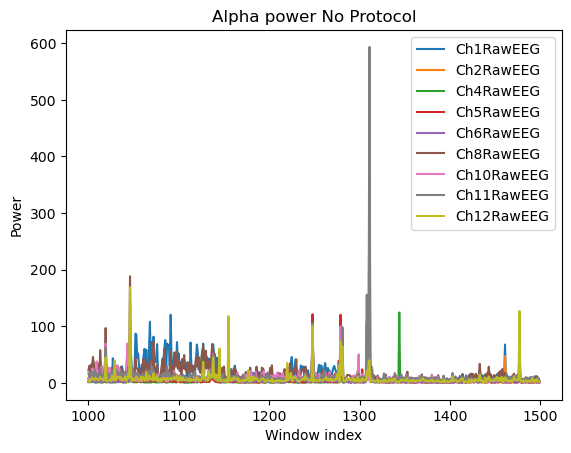

In [50]:
no_protocol_alpha_df.iloc[1000:1500].plot()
plt.xlabel('Window index')
plt.ylabel('Power')
plt.title('Alpha power No Protocol')

## Removing outliers

In [51]:
threshold=100
print('For each dataset')
percept_data_kept = sum((no_protocol_alpha_df < threshold).all(axis=1))/len(no_protocol_alpha_df)*100
print(f'Percent of data kept after removing outliers: {int(percept_data_kept)}%')
percept_data_kept = sum((focus_protocol_alpha_df < threshold).all(axis=1))/len(focus_protocol_alpha_df)*100
print(f'Percent of data kept after removing outliers: {int(percept_data_kept)}%')


For each dataset
Percent of data kept after removing outliers: 94%
Percent of data kept after removing outliers: 87%


In [52]:
def remove_outliers(df, threshold=100):
    return df[(df < threshold).all(axis=1)]

In [53]:
focus_protocol_alpha_df_cleaned = remove_outliers(focus_protocol_alpha_df)
no_protocol_alpha_df_cleaned = remove_outliers(no_protocol_alpha_df)

Text(0.5, 1.0, 'Alpha power after Protocol')

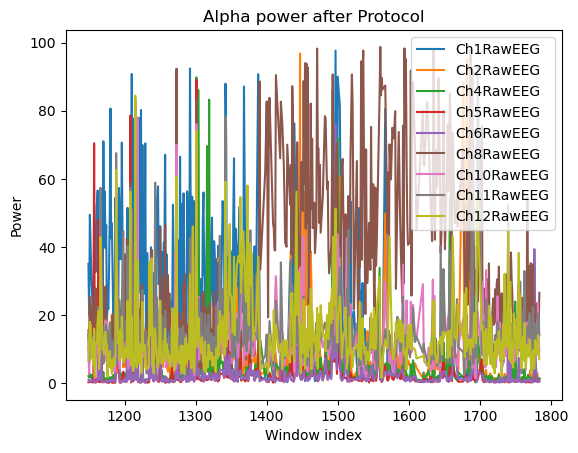

In [54]:
focus_protocol_alpha_df_cleaned.iloc[1000:1500].plot()
plt.xlabel('Window index')
plt.ylabel('Power')
plt.title('Alpha power after Protocol')

Text(0.5, 1.0, 'Alpha power No Protocol')

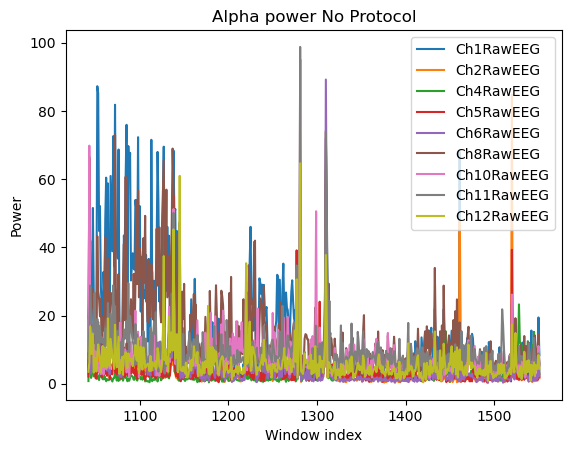

In [55]:
no_protocol_alpha_df_cleaned.iloc[1000:1500].plot()
plt.xlabel('Window index')
plt.ylabel('Power')
plt.title('Alpha power No Protocol')

It looks like after the protocol, I have much more alpha power. Is it brain data or is it artifacts? Let me check a different window. 

Text(0.5, 1.0, 'Alpha power after Protocol')

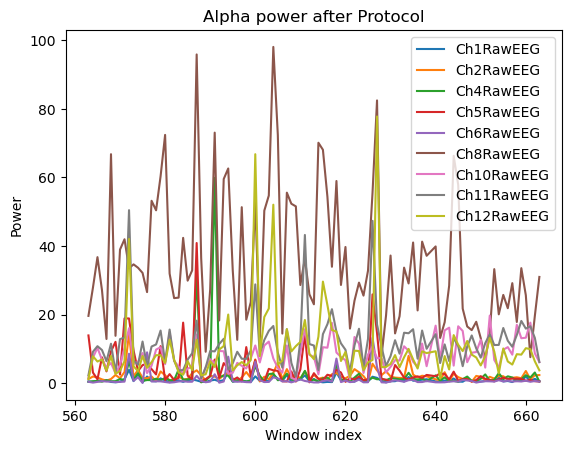

In [56]:
focus_protocol_alpha_df_cleaned.iloc[500:600].plot()
plt.xlabel('Window index')
plt.ylabel('Power')
plt.title('Alpha power after Protocol')

Text(0.5, 1.0, 'Alpha power No Protocol')

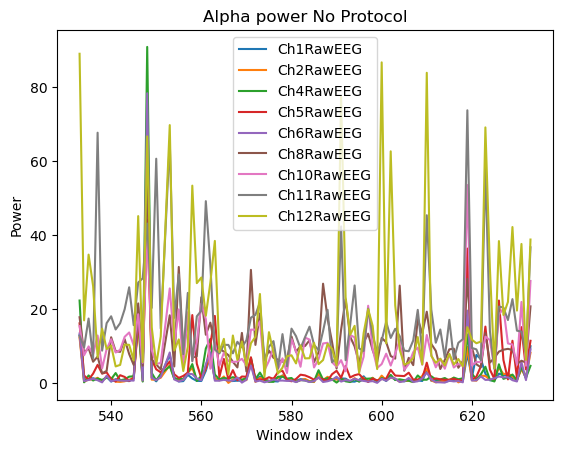

In [57]:
no_protocol_alpha_df_cleaned.iloc[500:600].plot()
plt.xlabel('Window index')
plt.ylabel('Power')
plt.title('Alpha power No Protocol')

## Saving features

In [60]:
if not os.path.exists('../data/features/'):
    os.makedirs('../data/features/')
focus_protocol_alpha_df_cleaned.to_csv('../data/features/focus_protcol_alpha_cleaned.csv', index=False)
no_protocol_alpha_df_cleaned.to_csv('../data/features/no_protcol_alpha_cleaned.csv', index=False)